In [15]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv(r"C:\Downloads\Corn_data_merged_3_region\corn_progress_all_years_3region.csv")
df.head()
df = df[df["state_name"] != "NORTH DAKOTA"]

In [17]:
print("THÔNG TIN DỮ LIỆU:")
df.info()

THÔNG TIN DỮ LIỆU:
<class 'pandas.core.frame.DataFrame'>
Index: 11238 entries, 0 to 11889
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         11238 non-null  int64  
 1   state_name   11238 non-null  object 
 2   state_alpha  11238 non-null  object 
 3   region       11238 non-null  object 
 4   week_ending  11238 non-null  object 
 5   week         11238 non-null  int64  
 6   planted      11238 non-null  float64
 7   emerged      11238 non-null  float64
 8   silking      11238 non-null  float64
 9   doughing     11238 non-null  float64
 10  dented       11238 non-null  float64
 11  mature       11238 non-null  float64
 12  harvested    11238 non-null  float64
dtypes: float64(7), int64(2), object(4)
memory usage: 1.2+ MB


In [18]:
# Xác định cột giai đoạn (điền theo đúng tên cột trong file)
stage_cols = ['planted', 'emerged', 'silking', 'doughing', 'dented', 'mature', 'harvested']

# Lọc các dòng mà tất cả giai đoạn đều bằng 0
empty_weeks = df[df[stage_cols].sum(axis=1) == 0]

print(f"\nSố tuần không có tiến trình: {len(empty_weeks)}")
empty_weeks.head()


Số tuần không có tiến trình: 510


,year,state_name,state_alpha,region,week_ending,week,planted,emerged,silking,doughing,dented,mature,harvested
8,2005,COLORADO,CO,Semi-Arid Continental,2005-06-26,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,2005,IOWA,IA,Temperate Humid,2005-06-26,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,2005,IOWA,IA,Temperate Humid,2005-07-03,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0
182,2005,MICHIGAN,MI,Temperate Humid,2005-06-26,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183,2005,MICHIGAN,MI,Temperate Humid,2005-07-03,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:

# 1. Chuẩn hoá dữ liệu
df['week_ending'] = pd.to_datetime(df['week_ending'], errors='coerce')
df['year'] = df['week_ending'].dt.year

region_col = 'region'
state_col = next((c for c in ['state_name','state','state_alpha'] if c in df.columns), None)

stage_cols = [c for c in ['planted','emerged','silking','doughing','dented','mature','harvested'] if c in df.columns]

# 2. Giữ tuần có hoạt động
active = df[df[stage_cols].gt(0).any(axis=1)].copy()

# 3. Lấy ngày bắt đầu và kết thúc của từng bang theo từng năm
by_state_year = (
    active.sort_values('week_ending')
          .groupby([region_col, state_col, 'year'])['week_ending']
          .agg(start_date='first', end_date='last')
          .reset_index()
)

# 4. Chuyển sang day-of-year (DOY) để bỏ năm
by_state_year['start_doy'] = by_state_year['start_date'].dt.dayofyear
by_state_year['end_doy']   = by_state_year['end_date'].dt.dayofyear

# 5. Trung bình DOY theo từng bang (qua các năm)
state_avg = (
    by_state_year.groupby([region_col, state_col])[['start_doy','end_doy']]
                 .mean()
                 .reset_index()
)

# 6. Trung bình DOY giữa các bang -> vùng
region_avg = (
    state_avg.groupby(region_col)[['start_doy','end_doy']]
             .mean()
             .round()
             .astype(int)
             .reset_index()
)

# 7. Chuyển DOY thành tháng-ngày (bỏ năm)
ref = pd.Timestamp('2001-01-01')   # năm không nhuận
region_avg['start_date'] = (ref + pd.to_timedelta(region_avg['start_doy']-1, unit='D')).dt.strftime('%m-%d')
region_avg['end_date']   = (ref + pd.to_timedelta(region_avg['end_doy']-1,   unit='D')).dt.strftime('%m-%d')

# 8. Giữ đúng cấu trúc cần
region_timeline = region_avg[[region_col, 'start_date', 'end_date']]

print("\nNGÀY BẮT ĐẦU – KẾT THÚC TRUNG BÌNH CỦA CÁC TỪNG VÙNG:")
region_timeline



NGÀY BẮT ĐẦU – KẾT THÚC TRUNG BÌNH CỦA CÁC TỪNG VÙNG:


,region,start_date,end_date
0,Semi-Arid Continental,04-11,11-22
1,Subtropical Humid,04-08,11-21
2,Temperate Humid,04-18,11-23


In [20]:


# 1. Chuẩn hoá dữ liệu
df['week_ending'] = pd.to_datetime(df['week_ending'], errors='coerce')
df['week'] = df['week'].astype(int)

# Thứ tự giai đoạn đúng quy trình sinh trưởng
stage_cols = ['planted', 'emerged', 'silking', 'doughing', 'dented', 'mature', 'harvested']

# 2. Tính trung bình từng tuần theo vùng
avg = (
    df.groupby(['region', 'week'])[stage_cols]
      .mean()
      .reset_index()
)

# 3. Xác định tuần bắt đầu, kết thúc, và số tuần cho từng giai đoạn
rows = []
for region, g in avg.groupby('region'):
    for stage in stage_cols:     # duyệt đúng thứ tự đã định nghĩa
        sub = g[g[stage] > 0]
        if sub.empty:
            continue
        start_week = int(sub['week'].iloc[0])
        end_week = int(sub['week'].iloc[-1])
        duration = int(round(end_week - start_week))
        rows.append({
            'region': region,
            'stage': stage,
            'start_week': start_week,
            'end_week': end_week,
            'weeks': duration
        })

# 4. Giữ nguyên thứ tự stage theo danh sách gốc, không sort chữ cái
summary = pd.DataFrame(rows)
summary['stage'] = pd.Categorical(summary['stage'], categories=stage_cols, ordered=True)
summary = summary.sort_values(['region', 'stage'], key=lambda col: col.map({s: i for i, s in enumerate(stage_cols)}))

# 5. Pivot bảng (hàng = vùng, cột = giai đoạn)
summary_pivot = summary.pivot(index='region', columns='stage', values='weeks')

# 6. Làm tròn và hiển thị
summary_pivot = summary_pivot.round(0).astype('Int64')

summary_pivot


stage,planted,emerged,silking,doughing,dented,mature,harvested
region,,,,,,,
Semi-Arid Continental,21,17,18,16,18,19,24
Subtropical Humid,13,13,13,14,14,15,21
Temperate Humid,16,15,16,17,16,17,19


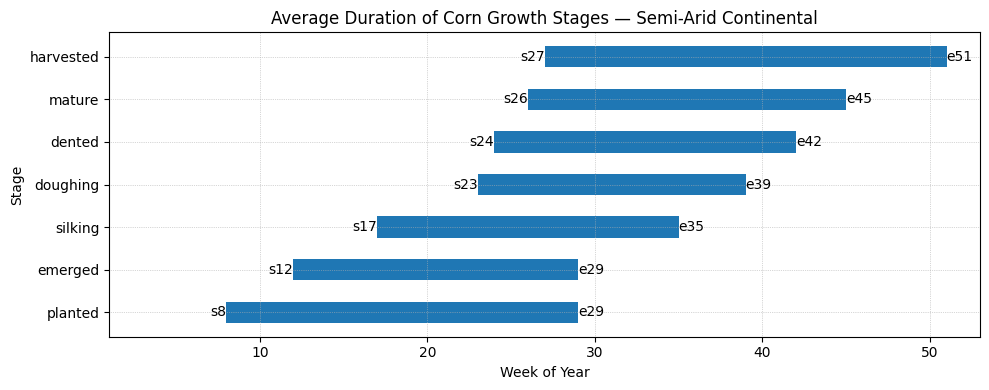

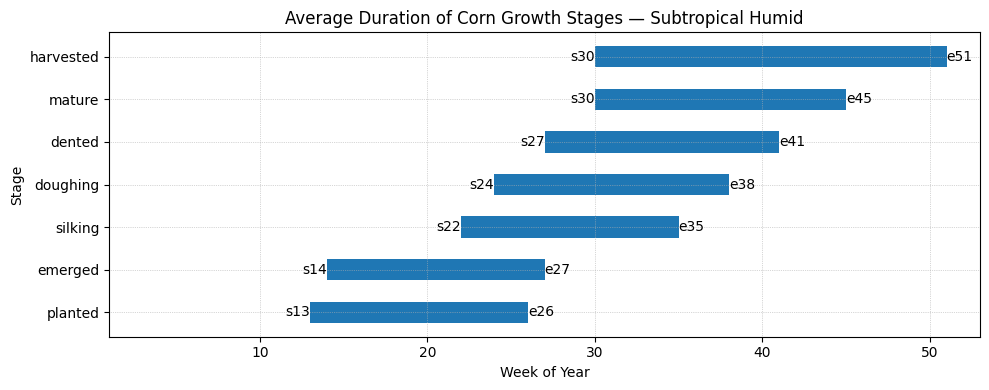

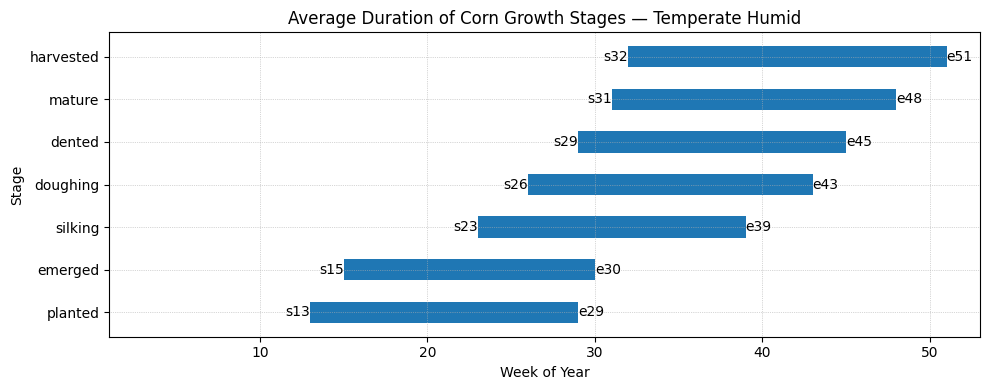

In [21]:
stage_cols = ['planted', 'emerged', 'silking', 'doughing', 'dented', 'mature', 'harvested']

def plot_stage_by_region(region_name, df_region):
    # Ép cột 'stage' theo thứ tự cố định
    df_region = df_region.copy()
    df_region['stage'] = pd.Categorical(df_region['stage'], categories=stage_cols, ordered=True)
    df_region = df_region.sort_values('stage')  # giờ sort này theo thứ tự stage_cols, không phải alphabet

    plt.figure(figsize=(10, 4))
    plt.barh(df_region['stage'], df_region['weeks'], left=df_region['start_week'], height=0.5)

    for stage, s, e in zip(df_region['stage'], df_region['start_week'], df_region['end_week']):
        plt.text(s, stage, f"s{s}", va='center', ha='right')
        plt.text(e, stage, f"e{e}", va='center', ha='left')

    plt.title(f"Average Duration of Corn Growth Stages — {region_name}")
    plt.xlabel("Week of Year")
    plt.ylabel("Stage")
    plt.xlim(1, 53)
    plt.grid(True, axis='both', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Vẽ biểu đồ cho từng vùng
for region_name, sub in summary.groupby('region'):
    plot_stage_by_region(region_name, sub)